In [1]:
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import torch
from mnist import MNIST
import pickle
import torchvision
import torch.nn.functional as F

import time
from sklearn import metrics

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from captum.robust import FGSM
from captum.robust import PGD


In [2]:
model_path = './VDKCNNet.pt'

In [3]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1000

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10/train/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./CIFAR10/test/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [5]:
images.shape

torch.Size([1000, 3, 32, 32])

In [6]:
trainset.targets
labels_ohe = np.zeros((len(trainset.targets), 10))
for i in range(len(trainset.targets)):
    labels_ohe[i,trainset.targets[i]] = 1
    
labels_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

### Models

In [7]:
device = torch.device('cuda:0')

In [8]:
class ScaledCNN(torch.nn.Module):
    def __init__(self,input_ch=3,feature_out=10):
        super(ScaledCNN,self).__init__()
        self.input_ch = input_ch
        self.feature_out = feature_out
        
        self.conv11 = torch.nn.Conv2d(self.input_ch,64,(8,8),padding='same')
        self.conv12 = torch.nn.Conv2d(self.input_ch,64,(8,8),padding='same')
        self.conv13 = torch.nn.Conv2d(self.input_ch,64,(8,8),padding='same')
        self.act11 = torch.nn.ReLU()
        self.act12 = torch.nn.ReLU()
        self.act13 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d((2,2)) # 16
        self.pool2 = torch.nn.MaxPool2d((2,2)) # 16
        self.pool3 = torch.nn.MaxPool2d((2,2)) # 16
        self.conv21 = torch.nn.Conv2d(128,64,(3,3),padding='same')
        self.conv22 = torch.nn.Conv2d(128,64,(3,3),padding='same')
        self.act21 = torch.nn.ReLU()
        self.act22 = torch.nn.ReLU()
        self.flt = torch.nn.Flatten()
        
        self.lin1 = torch.nn.Linear(4096,1024)
        self.lin2 = torch.nn.Linear(1024,128)
        self.lin3 = torch.nn.Linear(128,10)
        self.rel1 = torch.nn.ReLU()
        self.rel2 = torch.nn.ReLU()
        
#         self.sig = torch.nn.Softmax(dim=1) # Log-softmax
        
    
    def forward(self,x):
        x1 = torch.nn.functional.avg_pool2d(x,(2,2))
        x2 = torch.nn.functional.avg_pool2d(x1,(2,2))
        x = self.act11(self.conv11(x))
        x = self.pool1(x) # 16
        
        x1c = self.act12(self.conv12(x1))
        x = torch.concat((x,x1c),dim=1)
        x = self.act21(self.conv21(x))
        x = self.pool2(x) # 8
        
        x2c = self.act13(self.conv13(x2))
        x = torch.concat((x,x2c),dim=1)
        x = self.act22(self.conv22(x))
        x = torch.flatten(x,1)
        
        x = self.rel1(self.lin1(x))
        x = self.rel2(self.lin2(x))
        x = self.lin3(x)
#         x = self.sig(x)
        
        return x

In [9]:
mod_image = ScaledCNN()
s = summary(mod_image,(3,32,32),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          12,352
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          12,352
              ReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          73,792
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          12,352
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          73,792
             ReLU-12             [-1, 64, 8, 8]               0
           Linear-13                 [-1, 1024]       4,195,328
             ReLU-14                 [-

/home/mshifathossain/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


In [10]:
mod_image.to(device)

ScaledCNN(
  (conv11): Conv2d(3, 64, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (conv12): Conv2d(3, 64, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (conv13): Conv2d(3, 64, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (act11): ReLU()
  (act12): ReLU()
  (act13): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv22): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act21): ReLU()
  (act22): ReLU()
  (flt): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=4096, out_features=1024, bias=True)
  (lin2): Linear(in_features=1024, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=10, bias=True)

### Training

In [11]:
def predict_cls(imageDat):

    with torch.no_grad():
        embds = mod_image(torch.Tensor(imageDat).to(device))
     
    pred_vals = []
    for i in range(len(embds)):
        pred_vals.append(int(torch.argmax(embds[i:i+1])))
        
        
    return np.asarray(pred_vals)

In [12]:
trainimages = trainset.data
trainimages = np.moveaxis(trainimages,3,1)
trainlabels = trainset.targets

testimages = testset.data
testimages = np.moveaxis(testimages,3,1)
testlabels = testset.targets

In [42]:
def modelTrain(dataloader,model,num_epoch=10,load_checkpoint = False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     optim = torch.optim.Adam(model.parameters(),lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
    optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    lossFunc = torch.nn.CrossEntropyLoss()
#     lossFunc = torch.nn.MultiLabelSoftMarginLoss()
#     lossFunc = torch.nn.NLLLoss()
#     lossFunc = torch.nn.BCEWithLogitsLoss()
#     lossFunc = torch.nn.BCELoss()
    
    
    epoch_s = 0
    loss_v = []
    accuracy_tr = []
    accuracy_ts = []
    t_epoch = 0
    
    if load_checkpoint:
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_s = checkpoint['epoch']
        loss_v = checkpoint['loss']
        accuracy_tr = checkpoint['accuracy_tr']
        accuracy_ts = checkpoint['accuracy_ts']
        t_epoch = checkpoint['epochTime']
    
    model.to(device)
    model.train()
    
    acc_ts_p = 0
    
    for epoch in range(num_epoch):
        tp = time.time()
        losses = 0
        
        label_pred = []
        label_tar = []
        
        
        for i, data in enumerate(dataloader, 0):
            optim.zero_grad()
            
            inputs, labels = data

            lbs = predict_cls(inputs)
            for i in range(len(lbs)):
                label_pred.append(lbs[i])
                label_tar.append(labels[i])
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
#             labels_ohe = np.zeros((len(labels), 10))
#             for j in range(len(labels)):
#                 labels_ohe[j,labels[j]] = 1
            
            y_labels = model(inputs)

            loss = lossFunc(y_labels,labels)
            loss.backward()
            
            optim.step()
            losses += loss.data.tolist()
            
            
#             if i % 10 == 9:    # print every 2000 mini-batches
#                 print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses / 10:.3f}')
#                 losses = 0.0
        
        

        y_tl = predict_cls(testimages)
        tl = testlabels
        
        tn = time.time()
        losses = losses/num_epoch
        loss_v.append(losses)
    
        label_pred = np.asarray(label_pred)
        label_tar = np.asarray(label_tar)
        
        accVal = metrics.accuracy_score(label_tar,label_pred)*100
        accuracy_tr.append(accVal)
        
        accVal_ts = metrics.accuracy_score(tl,y_tl)*100
        accuracy_ts.append(accVal_ts)
        
    
        print('Epoch: {}, Epoch time (s): {}, Total loss: {}, Train Accuracy: {}%, Test Accuracy: {}%'.format(epoch+epoch_s+1,round(tn-tp,3),round(losses,4),round(accVal,2),round(accVal_ts,2)))

        if acc_ts_p < accVal_ts:
            torch.save({
                'epoch': epoch+epoch_s+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'loss': loss_v,
                'accuracy_tr': accuracy_tr,
                'accuracy_ts': accuracy_ts,
                'epochTime': tn-tp
                }, model_path)
        
            acc_ts_p = accVal_ts
            

In [43]:
modelTrain(trainloader,mod_image,num_epoch=1000)

Epoch: 1, Epoch time (s): 4.428, Total loss: 0.1152, Train Accuracy: 10.0%, Test Accuracy: 11.87%
Epoch: 2, Epoch time (s): 4.401, Total loss: 0.1151, Train Accuracy: 10.0%, Test Accuracy: 11.19%
Epoch: 3, Epoch time (s): 4.342, Total loss: 0.1151, Train Accuracy: 10.0%, Test Accuracy: 10.36%
Epoch: 4, Epoch time (s): 4.445, Total loss: 0.1151, Train Accuracy: 10.0%, Test Accuracy: 9.47%
Epoch: 5, Epoch time (s): 4.427, Total loss: 0.115, Train Accuracy: 10.0%, Test Accuracy: 9.28%
Epoch: 6, Epoch time (s): 4.42, Total loss: 0.115, Train Accuracy: 10.0%, Test Accuracy: 9.39%
Epoch: 7, Epoch time (s): 4.461, Total loss: 0.115, Train Accuracy: 10.02%, Test Accuracy: 9.66%
Epoch: 8, Epoch time (s): 4.432, Total loss: 0.1149, Train Accuracy: 10.11%, Test Accuracy: 10.05%
Epoch: 9, Epoch time (s): 4.449, Total loss: 0.1149, Train Accuracy: 10.8%, Test Accuracy: 10.5%
Epoch: 10, Epoch time (s): 4.453, Total loss: 0.1148, Train Accuracy: 12.88%, Test Accuracy: 10.81%
Epoch: 11, Epoch time (s)

KeyboardInterrupt: 

### Inference

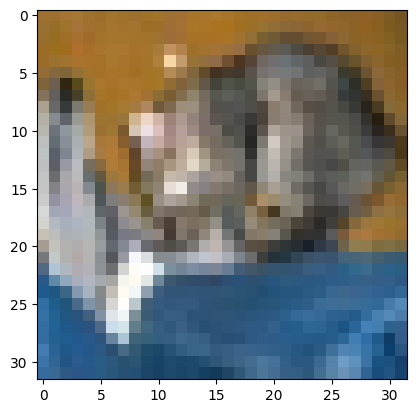

In [16]:
plt.imshow(testset.data[0])

In [23]:
with torch.no_grad():
    embds = mod_image(torch.Tensor(trainimages[0:30]).to(device))
    
embds

tensor([[ 1.8689e+02,  1.3765e+01, -2.5964e+01,  1.5438e+01, -7.7624e+01,
          2.6441e+01, -1.5391e+02, -4.5008e+01,  1.4488e+02,  4.9805e+01],
        [ 3.4278e+02,  4.7591e+01, -5.3728e+01, -6.5276e+00, -1.5164e+02,
          1.4105e+01, -2.9076e+02, -8.0768e+01,  2.9247e+02,  1.1377e+02],
        [ 3.3716e+02,  7.5736e+01, -5.1579e+01, -2.4856e+01, -1.6693e+02,
         -1.7557e+01, -2.9641e+02, -7.3245e+01,  3.1219e+02,  1.5321e+02],
        [ 1.6234e+02,  1.4477e+01, -2.3873e+01,  7.8726e+00, -6.8730e+01,
          1.9089e+01, -1.3387e+02, -3.8964e+01,  1.2971e+02,  4.4763e+01],
        [ 2.8608e+02,  4.7032e+01, -4.5477e+01, -1.1421e+01, -1.3231e+02,
          3.8187e+00, -2.4646e+02, -6.6967e+01,  2.5285e+02,  1.0542e+02],
        [ 1.6465e+02,  3.7664e+01, -2.5525e+01, -3.0729e+00, -8.4192e+01,
         -7.6080e-01, -1.4824e+02, -3.8038e+01,  1.5178e+02,  7.5710e+01],
        [ 2.6749e+02,  3.5782e+01, -3.8855e+01, -3.0976e+00, -1.1839e+02,
          1.0669e+01, -2.2798e+0

### Testing

In [13]:
checkpoint = torch.load(model_path)
mod_image.load_state_dict(checkpoint['model_state_dict'])
print('Loss: ', checkpoint['loss'][-1])
print('Train accuracy: ', checkpoint['accuracy_tr'][-1])
print('Test accuracy: ', checkpoint['accuracy_ts'][-1])
mod_image.eval()

Loss:  0.008298473328351975
Train accuracy:  95.46
Test accuracy:  50.74999999999999


ScaledCNN(
  (conv11): Conv2d(3, 64, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (conv12): Conv2d(3, 64, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (conv13): Conv2d(3, 64, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (act11): ReLU()
  (act12): ReLU()
  (act13): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv22): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act21): ReLU()
  (act22): ReLU()
  (flt): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=4096, out_features=1024, bias=True)
  (lin2): Linear(in_features=1024, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=10, bias=True)

In [14]:
tr_testimages = []

mod_image.cpu()

for i in range(len(testimages)):
    tr_testimages.append(transform(np.transpose(testimages[i],(1,2,0))))
    
tr_testimages = torch.stack(tr_testimages)

_,y_tl = torch.max(mod_image(tr_testimages.cpu()),axis=1)
tl = testlabels

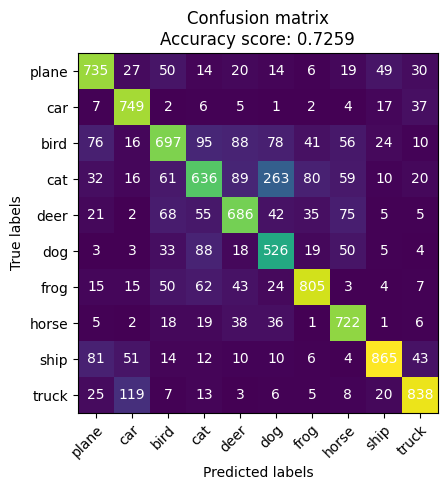

In [15]:
conf_mat = metrics.confusion_matrix(y_tl,tl)

fig, ax = plt.subplots()
im = ax.imshow(conf_mat)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(classes)), labels=classes)
ax.set_yticks(np.arange(len(classes)), labels=classes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, conf_mat[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion matrix\nAccuracy score: {}".format(metrics.accuracy_score(y_tl,tl)))
fig.tight_layout()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### Attributes

In [18]:
# Good: 6, 8b, 9
# Good class: 8, 9
ind = 9

in_dat = torch.unsqueeze(transform(np.transpose(testimages[ind],(1,2,0))),0)

in_dat = in_dat.to(device)
in_dat.requires_grad = True

in_label = testlabels[ind:ind+1]

mod_image.cuda()
outputs = mod_image(in_dat)
_ , predicted = torch.max(outputs, 1)

In [19]:
def attribute_image_features(algorithm, in_dat, **kwargs):
    mod_image.zero_grad()
    tensor_attributions = algorithm.attribute(in_dat,
                                              target=in_label,
                                              **kwargs
                                             )
    
    return tensor_attributions

In [20]:
saliency = Saliency(mod_image)
grads = saliency.attribute(in_dat, target=in_label)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [21]:
ig = IntegratedGradients(mod_image)
attr_ig, delta = attribute_image_features(ig, in_dat, baselines=in_dat * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0457], device='cuda:0', dtype=torch.float64)


In [22]:
ig = IntegratedGradients(mod_image)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, in_dat, baselines=in_dat * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [23]:
dl = DeepLift(mod_image)
attr_dl = attribute_image_features(dl, in_dat, baselines=in_dat * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/home/mshifathossain/.local/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Original Image
Origina Label: car
Predicted: car  Probability: 0.9997232556343079


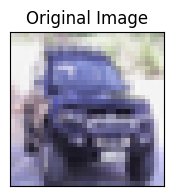

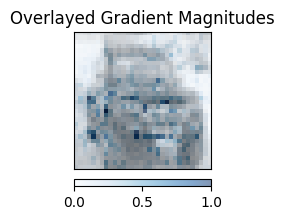

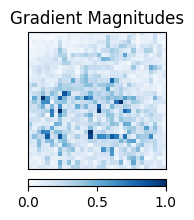

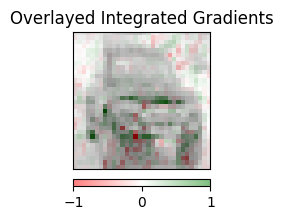

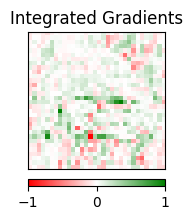

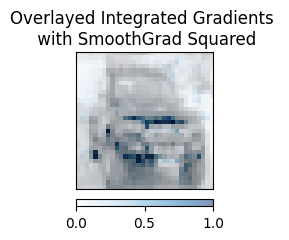

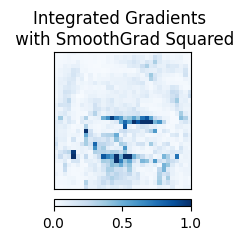

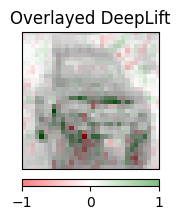

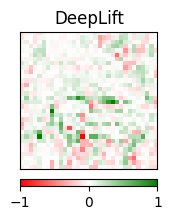

In [24]:
print('Original Image')
print('Origina Label: {}'.format(classes[in_label[0]]))
print('Predicted:', classes[predicted], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())


original_image = np.transpose(np.squeeze(in_dat.cpu().detach().numpy() / 2) + 0.5,(1,2,0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image",fig_size=(2,2))


_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes",fig_size=(2,2))
_ = viz.visualize_image_attr(grads, original_image, method="heat_map", sign="absolute_value",
                          show_colorbar=True, title="Gradient Magnitudes",fig_size=(2,2))


_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients",fig_size=(2,2))
_ = viz.visualize_image_attr(attr_ig, original_image, method="heat_map",sign="all",
                          show_colorbar=True, title="Integrated Gradients",fig_size=(2,2))


_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared",fig_size=(2,2))
_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Integrated Gradients \n with SmoothGrad Squared",fig_size=(2,2))


_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift",fig_size=(2,2))
_ = viz.visualize_image_attr(attr_dl, original_image, method="heat_map",sign="all",show_colorbar=True, 
                          title="DeepLift",fig_size=(2,2))

### Robustness

In [25]:
normalize = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
unnormalize = lambda x: 0.5*x + 0.5

def image_show(img, pred):
    npimg = img.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    plt.figure(figsize=(2,2))
    plt.imshow(npimg)
    plt.title("prediction: %s" % pred)
    plt.show()
    
def get_prediction(model, inpt, normalize_im=False):
    if normalize_im:
        inpt = normalize(inpt)
    output = model(inpt)
    _, pred = torch.max(output, dim=1)
    return classes[pred], F.softmax(output)[:,pred]

def get_prediction_l(model, inpt, normalize_im=False):
    if normalize_im:
        inpt = normalize(inpt)
    output = model(inpt)
    _, pred = torch.max(output, dim=1)
    return pred, F.softmax(output)[:,pred]

In [26]:
pred, score = get_prediction(mod_image,in_dat,normalize_im=False)

/tmp/ipykernel_667638/720286228.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return classes[pred], F.softmax(output)[:,pred]


#### FGSM Attacker

In [27]:
# Construct FGSM attacker
fgsm = FGSM(mod_image, lower_bound=0, upper_bound=1)
perturbed_image_fgsm = fgsm.perturb(in_dat / 2 + 0.5, epsilon=0.16, target=in_label) 
new_pred_fgsm, score_fgsm = get_prediction(mod_image, perturbed_image_fgsm)

/tmp/ipykernel_667638/720286228.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return classes[pred], F.softmax(output)[:,pred]


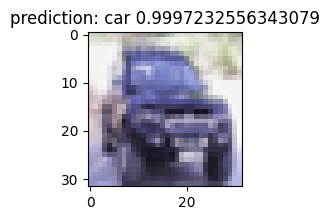

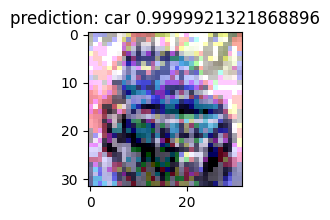

In [28]:
image_show(in_dat / 2 + 0.5, pred+ " " + str(score.item()))
image_show(perturbed_image_fgsm, new_pred_fgsm + " " + str(score_fgsm.item()))

In [29]:


confMat_fgsm = np.zeros((10,10))
tr_testimages = []

for i in range(len(testimages)):
    tr_testimages.append(transform(np.transpose(testimages[i],(1,2,0))))
    
tr_testimages = torch.stack(tr_testimages)

# ytest_pred = torch.max(net(tr_testimages),axis=1)
ytest_pred, ytest_score = get_prediction_l(mod_image.cpu(), tr_testimages)


fgsm = FGSM(mod_image, lower_bound=0, upper_bound=1)
perturbed_image_fgsm = fgsm.perturb(tr_testimages / 2 + 0.5, epsilon=0.16, target=testlabels) 
new_pred_fgsm, score_fgsm = get_prediction_l(mod_image.cpu(), perturbed_image_fgsm)


s_indx = ytest_pred == torch.Tensor(testlabels)

/tmp/ipykernel_667638/720286228.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return pred, F.softmax(output)[:,pred]
/home/mshifathossain/.local/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


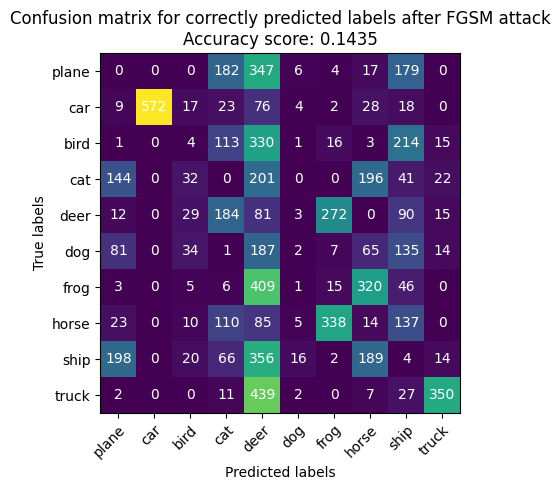

In [37]:
conf_mat = metrics.confusion_matrix(ytest_pred[s_indx],new_pred_fgsm[s_indx])

fig, ax = plt.subplots()
im = ax.imshow(conf_mat)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(classes)), labels=classes)
ax.set_yticks(np.arange(len(classes)), labels=classes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, conf_mat[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion matrix for correctly predicted labels after FGSM attack\nAccuracy score: {}".format(
    round(metrics.accuracy_score(ytest_pred[s_indx],new_pred_fgsm[s_indx]),4)))
fig.tight_layout()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [33]:
metrics.accuracy_score(testlabels,new_pred_fgsm)

0.1569

#### Gaussian Blur

In [17]:
from captum.robust import MinParamPerturbation

In [18]:
def gaussian_blur(image, kernel_size):
    blur = torchvision.transforms.GaussianBlur(kernel_size)
    return blur(image)

In [19]:
min_pert = MinParamPerturbation(forward_func=mod_image.cpu(), attack=gaussian_blur, arg_name="kernel_size", mode="linear",
                               arg_min=1, arg_max=31, arg_step=2, num_attempts=5)


In [338]:
alt_im, kernel_size = min_pert.evaluate(in_dat.cpu().detach(), target=in_label)
print("Minimum Kernel Size for Misclassification: ", kernel_size)

Minimum Kernel Size for Misclassification:  3


/tmp/ipykernel_565369/1538402187.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return classes[pred], F.softmax(output)[:,pred]


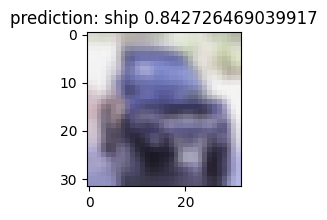

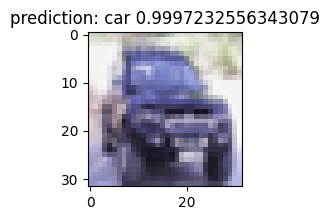

In [339]:
# Blurred Image
if alt_im == None:
    alt_im = gaussian_blur(in_dat.cpu().detach(),11)
new_pred_blur, score_blur = get_prediction(mod_image, alt_im)
image_show(alt_im / 2 + 0.5, new_pred_blur + " " + str(score_blur.item()))

# Original
image_show(in_dat / 2 + 0.5, pred+ " " + str(score.item()))

In [20]:
ks = []

tr_testimages_c = tr_testimages.cpu().detach()

for i in range(len(tr_testimages)):
    alt_im, kernel_size = min_pert.evaluate(tr_testimages_c[i:i+1], target=testlabels[i:i+1])
    ks.append(kernel_size)
# print("Minimum Kernel Size for Misclassification: ", kernel_size)

Text(0.5, 1.0, 'Histogram of misclassified images per minimum blur kernel size')

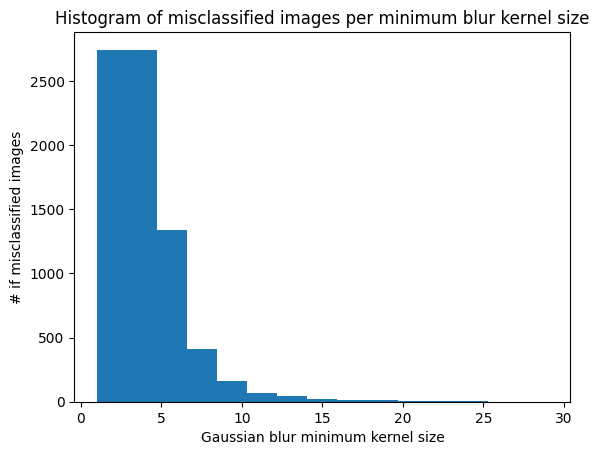

In [21]:
ks_np = np.asarray(ks)
n_indx = np.asarray(ks) == None
nn_indx = np.logical_not(n_indx)
ks_np[n_indx] = 33

plt.hist(ks_np[nn_indx],bins=15)
# hist_tics = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,'Infinite']
# plt.xticks(np.arange(len(hist_tics)), labels=hist_tics)
plt.xlabel('Gaussian blur minimum kernel size')
plt.ylabel('# if misclassified images')
plt.title('Histogram of misclassified images per minimum blur kernel size')

In [22]:
print('Immune samples: {}%'.format(round(np.sum(n_indx)/len(tr_testimages_c)*100,2)))
print('Affected samples: {}%'.format(round(np.sum(nn_indx)/len(tr_testimages_c)*100,2)))

Immune samples: 24.29%
Affected samples: 75.71%
